In [6]:
import pandas as pd
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import torch
import torch.nn as nn
import yaml
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm

sys.path.append("../input/modules")
from datasets import RainForestDataset
from utils import read_hdf5
from utils import down_sampler
from models import Cnn14_DecisionLevelAtt
from losses import FrameClipLoss
from datasets import FeatTrainCollater
from datasets import FeatEvalCollater
from utils import lwlrap
sys.path.append("../input/iterative-stratification-master")
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
train_tp = pd.read_csv('../input/rfcx-species-audio-detection/train_tp.csv')
train_fp = pd.read_csv('../input/rfcx-species-audio-detection/train_fp.csv')
submission = pd.read_csv('../input/rfcx-species-audio-detection/sample_submission.csv')
tmp = pd.DataFrame(train_tp["recording_id"].value_counts()).reset_index().rename(columns={'index': 'recording_id', "recording_id": "count"})
train_tp["t_diff"] = train_tp["t_max"] - train_tp["t_min"]
train_tp["f_diff"] = train_tp["f_max"] - train_tp["f_min"]
train_fp["t_diff"] = train_fp["t_max"] - train_fp["t_min"]
train_fp["f_diff"] = train_fp["f_max"] - train_fp["f_min"]
train_tp = pd.merge(train_tp, tmp, on="recording_id", how='inner')
train_tp["count"].value_counts()
tp_list = train_tp["recording_id"].unique()
fp_list = train_fp["recording_id"].unique()

In [8]:
tmp = pd.DataFrame(train_fp["recording_id"].value_counts()).reset_index().rename(columns={'index': 'recording_id', "recording_id": "count"})
train_fp = pd.merge(train_fp, tmp, on="recording_id", how='inner')
train_fp["count"].value_counts()

1     2028
2     1716
3     1635
4     1356
5      575
6      294
7      126
8       32
10      10
9        9
Name: count, dtype: int64

In [9]:
train_path_list = os.listdir("../input/rfcx-species-audio-detection/train")
test_path_list = os.listdir("../input/rfcx-species-audio-detection/test")
print(f"train:{len(train_path_list)}, test:{len(test_path_list)}")
# print("train")
# for path in tqdm(train_path_list):
#     path = os.path.join("../input/rfcx-species-audio-detection/train", path)
#     y, sr = librosa.load(path=path, sr=None)
#     if (sr != 48000) or (len(y) != 2880000):
#         print(path, y.shape, sr)
# print("test")
# for path in tqdm(test_path_list):
#     path = os.path.join("../input/rfcx-species-audio-detection/test", path)
#     y, sr = librosa.load(path=path, sr=None)
#     if (sr != 48000) or (len(y) != 2880000):
#         print(path, y.shape, sr)

train:4727, test:1992


In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(y)
plt.subplot(2, 2, 2)
plt.imshow(logmel.T, aspect="auto")

plt.colorbar()
y, sr = librosa.load(path=train_tp_list[10], sr=48000)
# y = (y -y.mean()) / y.std()
logmel = logmelfilterbank(
    y,
    sr,
    fft_size=2048,
    hop_size=512,
    win_length=None,
    window="hann",
    num_mels=128,
    fmin=50,
    fmax=16000,
    eps=1e-10,
)
plt.subplot(2, 2, 3)
plt.plot(y)
plt.subplot(2, 2, 4)
plt.imshow(logmel.T, aspect="auto")
plt.colorbar()

# plt.savefig("spec.png")

In [5]:
path = "dump/wave/train/551385b05.h5" # "dump/wave/train/c12e0a62b.h5"
wave = read_hdf5(hdf5_name=path, hdf5_path="wave")
mel = read_hdf5(hdf5_name=path, hdf5_path="feats")
matrix_tp = read_hdf5(hdf5_name=path, hdf5_path="matrix_tp")
matrix_fp = read_hdf5(hdf5_name=path, hdf5_path="matrix_fp")

# plt.figure(figsize=(16, 8))
# plt.subplot(2, 2, 1)
# plt.plot(wave)
# plt.subplot(2, 2, 2)
# plt.imshow(mel.T, aspect="auto")
# plt.colorbar()
# plt.subplot(2, 2, 3)
# plt.imshow(matrix_tp.T, aspect="auto")
# plt.subplot(2, 2, 4)
# plt.imshow(matrix_fp.T, aspect="auto")
# plt.colorbar()

In [6]:
y_frame = torch.stack([torch.tensor(down_sampler(matrix_tp[3000:3512])), torch.tensor(down_sampler(matrix_tp[4500:5012]))], dim=0)
y_clip = torch.tensor((y_frame>0).any(axis=1), dtype=torch.float)
x_batch = torch.stack([torch.tensor(mel[3000:3512]), torch.tensor(mel[4500:5012])], dim=0).transpose(2,1)
print(y_frame.shape, y_clip.shape)
model = Cnn14_DecisionLevelAtt(sample_rate=16000,
        window_size=1024,
        hop_size=256,
        mel_bins=64,
        fmin=50,
        fmax=8000,
        classes_num=24,
        training=False,
        require_prep=False,
        is_spec_augmenter=False,
        mixup_lambda=None,)
model.bn0 = nn.BatchNorm2d(128)
y = model(x_batch)
bce = nn.BCEWithLogitsLoss(reduction="mean")
print(y["y_frame"].shape, y["y_clip"].shape)

torch.Size([2, 16, 24]) torch.Size([2, 24])
torch.Size([2, 16, 24]) torch.Size([2, 24])


In [21]:
criterion = FrameClipLoss()
loss = criterion(y["y_frame"], y_frame, y["y_clip"], y_clip)
print(loss.item())
loss.backward(retain_graph=True)
# clip_loss = bce(y["y_clip"], y_clip)
# frame_loss = bce(y["y_frame"], y_frame)
# print(clip_loss.item())
# print(frame_loss.item())
# clip_loss.backward(retain_graph=True)
# frame_loss.backward(retain_graph=True)


0.9768208266970457


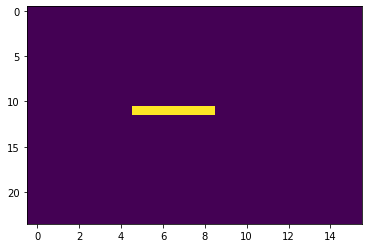

In [20]:
# sumpling function
source = y_frame[0]
new_source = torch.zeros_like(y["y_frame"][0])
l_source = 550
l_target = 16
l_effect = l_source // l_target
for i in range(l_target):
    t_start = i * l_effect
    t_end = (i+1) * l_effect
    if i == l_target -1:
        t_end = l_source
    new_source[i] = source[t_start:t_end].sum(axis=0) / l_effect
    new_source[i] = torch.tensor((source[t_start:t_end]>0).any(axis=0), dtype=torch.float)
plt.imshow(new_source.T, aspect="auto")

In [7]:
columns = ["recording_id"] + [f"s{i}" for i in range(24)]
ground_truth = pd.DataFrame(np.zeros((len(tp_list), 25)), columns=columns)
ground_truth["recording_id"] = train_tp["recording_id"].unique()
for i, recording_id in enumerate(train_tp["recording_id"].values):
    ground_truth.iloc[ground_truth["recording_id"]==recording_id, train_tp.loc[i, "species_id"]+1] = 1.0

In [8]:
kfold = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=1)
y = ground_truth.iloc[:, 1:].values
for i, (train_idx, valid_idx) in enumerate(kfold.split(y, y)):
    train_y = ground_truth.iloc[train_idx]
    valid_y = ground_truth.iloc[valid_idx]
    if i == 0:
        break

In [72]:
train_dataset = RainForestDataset(
    root_dir="dump/wave/train",
    train_tp=train_tp,
    train_fp=None,
    keys=["feats"],
    mode="tp",
    is_normalize=False,
    allow_cache=False,  # keep compatibility
    seed=None,
)
eval_dataset = RainForestDataset(
    files=[
        os.path.join("dump/wave/train", f"{recording_id}.h5")
        for recording_id in tp_list[valid_idx]
    ],
    keys=["feats", "matrix_tp"],
    mode="test",
    is_normalize=False,
    allow_cache=False,  # keep compatibility
    seed=None,
        )

train_collater = FeatTrainCollater(
    max_frames=512,
    l_target=16,
    mode="binary",
)
eval_collater = FeatEvalCollater(
    max_frames=512,
    n_split=3,
    is_label=True,
)
data_loader = {
"train": DataLoader(
        dataset=train_dataset,
        batch_size=64,
        collate_fn=train_collater,
        shuffle=False,
        num_workers=2,
        pin_memory=False,
    ),
"eval": DataLoader(
        eval_dataset,
        batch_size=64,
        shuffle=False,
        collate_fn=eval_collater,
        num_workers=2,
        pin_memory=False,
    ),
}
clip_list = []
for i, batch in enumerate(data_loader["train"]):
    x = batch["X"]
    y_frame = batch["y_frame"]
    y_clip = batch["y_clip"]
    clip_list.append(y_clip)
    print(x.shape)
    print(y_frame.shape)
    print(y_clip.shape)
    if i == 0:
        break

torch.Size([64, 128, 512])
torch.Size([64, 16, 24])
torch.Size([64, 24])


In [73]:
x1 = []
y1_clip = []
beginnings1 = []
for i, batch in enumerate(data_loader["train"]):
    x1.append(batch["X"])
    y1_clip.append(batch["y_clip"])
    beginnings1.append(batch["beginnings"])
    if i == 0:
        break
x2 = []
y2_clip = []
beginnings2 = []
for i, batch in enumerate(data_loader["train"]):
    x2.append(batch["X"])
    y2_clip.append(batch["y_clip"])
    beginnings2.append(batch["beginnings"])
    if i == 0:
        break
xx1 = torch.cat(x1, dim=0)
xx2 = torch.cat(x2, dim=0)
yy1_clip = torch.cat(y1_clip, dim=0)
yy2_clip = torch.cat(y2_clip, dim=0)
ans = xx1 - xx2
print(ans.sum())

tensor(71.8454)


In [74]:
print(beginnings1)
print(beginnings2)

[[4159, 3967, 3561, 4752, 4770, 139, 1709, 453, 4789, 4352, 4006, 4095, 4790, 2237, 1083, 393, 5114, 3312, 2058, 2733, 4134, 36, 4921, 552, 2313, 2090, 4460, 307, 5114, 4381, 331, 2956, 2355, 4934, 2271, 5114, 121, 1218, 3805, 69, 2588, 2939, 3434, 2556, 4591, 467, 4788, 1053, 2144, 4665, 184, 4093, 1652, 3517, 4917, 4549, 4290, 4281, 235, 3091, 4137, 2119, 308, 359]]
[[4002, 3972, 3795, 4887, 4792, 59, 1640, 389, 4713, 4327, 4142, 3974, 4741, 2362, 1129, 304, 5114, 3185, 2048, 4581, 4074, 13, 5114, 534, 2120, 2087, 4507, 431, 5114, 4496, 358, 3024, 2519, 4811, 2222, 5114, 27, 1287, 3783, 127, 2442, 2887, 3603, 2354, 4648, 595, 4775, 1098, 2233, 4667, 229, 4102, 1612, 3458, 4738, 4507, 4329, 4308, 139, 2962, 4024, 2212, 313, 320]]


In [19]:
print(beginnings1)
print(beginnings2)

[[4040, 3849, 3753, 4898, 4650, 125, 1638, 401, 4677, 4242, 4247, 3927, 4807, 2206, 1010, 407, 5114, 3114, 1998, 2933, 3978, 19, 5108, 506, 2324, 2164, 4581, 1092, 5114, 4512, 299, 2984, 2438, 4885, 2186, 5114, 74, 1179, 3824, 50, 2436, 3001, 3662, 2566, 4594, 444, 4838, 1127, 2232, 4783, 303, 4142, 1731, 3348, 4821, 4450, 4370, 4280, 234, 2933, 4166, 2206, 182, 508]]
[[4040, 3849, 3753, 4898, 4650, 125, 1638, 401, 4677, 4242, 4247, 3927, 4807, 2206, 1010, 407, 5114, 3114, 1998, 2933, 3978, 19, 5108, 506, 2324, 2164, 4581, 1092, 5114, 4512, 299, 2984, 2438, 4885, 2186, 5114, 74, 1179, 3824, 50, 2436, 3001, 3662, 2566, 4594, 444, 4838, 1127, 2232, 4783, 303, 4142, 1731, 3348, 4821, 4450, 4370, 4280, 234, 2933, 4166, 2206, 182, 508]]


In [70]:
import random
random.randrange(3)

1

In [10]:
x1 = []
y1_clip = []
for i, batch in enumerate(data_loader["train"]):
    x1.append(batch["X"])
    y1_clip.append(batch["y_clip"])
x2 = []
y2_clip = []
for i, batch in enumerate(data_loader["train"]):
    x2.append(batch["X"])
    y2_clip.append(batch["y_clip"])


In [12]:
xx1 = torch.cat(x1, dim=0)
xx2 = torch.cat(x2, dim=0)
yy1_clip = torch.cat(y1_clip, dim=0)
yy2_clip = torch.cat(y2_clip, dim=0)
ans = xx1 - xx2
print(ans.sum())

tensor(0.)


In [13]:
xx1.shape

torch.Size([1132, 128, 512])

In [34]:
mode = "valid"
n_eval_split = 3
device = "cpu"
n_class = 24
l_spec = 16
keys_list = [f"X{i}" for i in range(n_eval_split)]
y_clip = [
    torch.empty((0, n_class)).to(device)
    for _ in range(n_eval_split)
]
y_frame = [
    torch.empty((0, l_spec, n_class)).to(device)
    for _ in range(n_eval_split)
]
y_clip_true = torch.empty((0, n_class))
model.eval()
with torch.no_grad():
    for batch in data_loader["eval"]:
        if mode == "valid":
            y_clip_true = torch.cat([y_clip_true, batch["y_clip"]], dim=0)
        x_batchs = [batch[key].to(device) for key in keys_list]
        for i in range(n_eval_split):
            y_batch_ = model(x_batchs[i])
            y_clip[i] = torch.cat([y_clip[i], y_batch_["y_clip"]], dim=0)
            y_frame[i] = torch.cat([y_frame[i], y_batch_["y_frame"]], dim=0)
# (B, n_eval_split, n_class)
y_clip = torch.stack(y_clip, dim=0).detach().cpu().numpy()
# (B, n_eval_split, T, n_class)
y_frame = torch.stack(y_frame, dim=0).detach().cpu().numpy()
if mode == "valid":
    y_clip_true = y_clip_true.numpy()
    score = lwlrap(y_clip_true, y_clip.max(axis=0))
    print(f"score:{score:.6f}")


score:0.157265


In [30]:
y_clip.shape

(3, 227, 24)

In [33]:
y_frame_ = torch.stack(y_frame, dim=0).detach().cpu().numpy()
y_frame_.shape

(3, 227, 16, 24)

In [32]:
score

0.15726538047216912